In [1]:
from utils.config import Config
from model.fasterrcnn import FasterRCNNTrainer, FasterRCNN
import tensorflow as tf
from utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
from model.fasterrcnn import _fast_rcnn_loc_loss

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
%matplotlib notebook

In [5]:
config = Config()
config._parse({})

======user config========
{'max_size': 1000,
 'min_size': 600,
 'voc_data_dir': 'D:/DataClinic/simple-faster-rcnn-pytorch/VOCdevkit/VOC2007/'}
==========end============


In [6]:
dataset = Dataset(config)

In [21]:
img, bboxes, labels, scale = dataset[1]

In [8]:
for x in (img, bboxes, labels):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

print(scale)

shape: (1, 600, 900, 3) max: 2.64 min: -2.117904
shape: (1, 4) max: 898.19995 min: 88.28829
shape: (1,) max: 6 min: 6
1.8018018018018018


In [9]:
img_size = img.shape[1:3]

In [ ]:
bboxes = tf.cast(bboxes, dtype=tf.float32)
labels = tf.cast(labels, dtype=tf.float32)

In [10]:
VOC_BBOX_LABEL_NAMES = (
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

In [11]:
from utils.data import vis

<IPython.core.display.Javascript object>


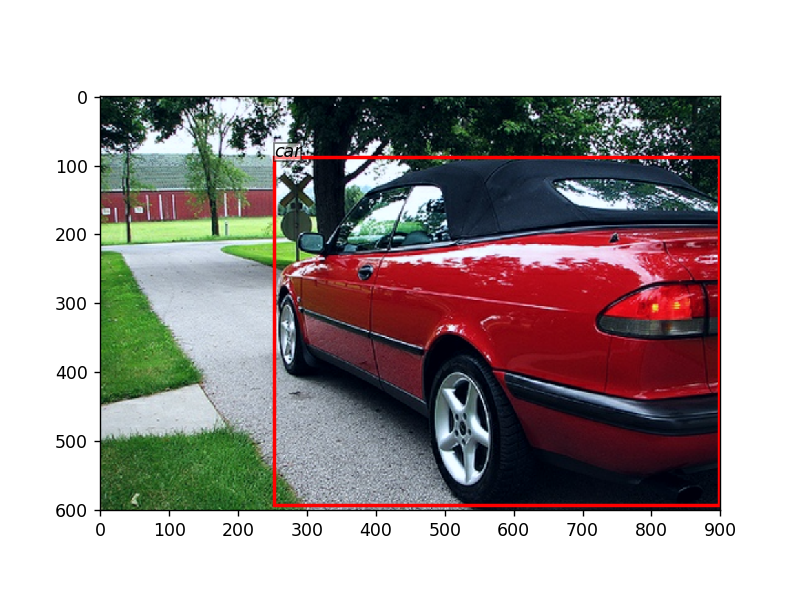

W0708 21:25:10.851469  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [12]:
vis(img[0], bboxes, labels)

In [13]:
frcnn = FasterRCNN(21, (7, 7))
model = FasterRCNNTrainer(frcnn)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
# 相当于build一下模型
img, bboxes, labels, scale = dataset[1]
bboxes_ = tf.cast(bboxes, dtype=tf.float32)
labels_ = tf.cast(labels, dtype=tf.float32)

_, _, _, _ = model(img, bboxes_, labels_, scale)
# 然后就能载入权重了
model.load_weights('frcnn.h5')

In [14]:
feature_map = model.faster_rcnn.extractor(img)
print('shape:', feature_map.shape)
print('max:', tf.reduce_max(feature_map).numpy())
print('min:', tf.reduce_min(feature_map).numpy())

shape: (1, 38, 57, 512)
max: 3.7585986
min: 0.0


In [15]:
f = tf.reduce_sum(feature_map, axis=-1)

<IPython.core.display.Javascript object>


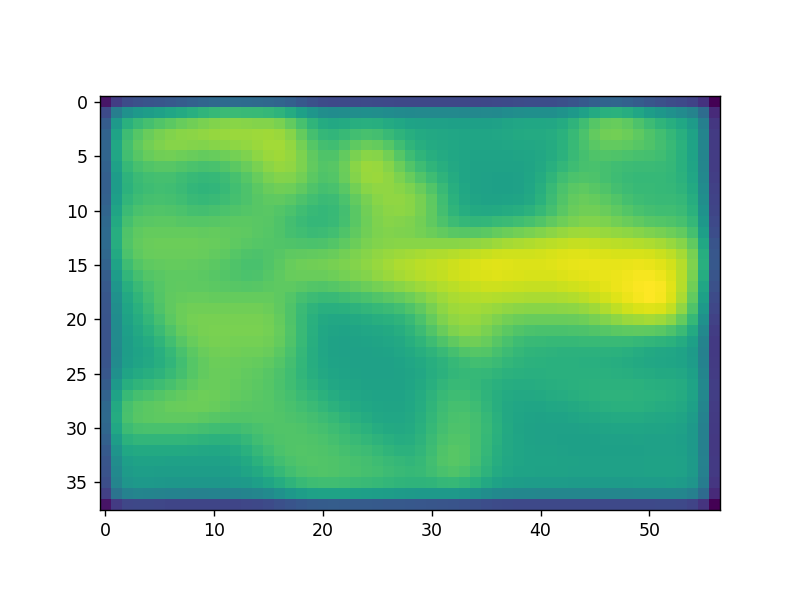

In [16]:
plt.imshow(f[0].numpy())

In [17]:
rpn_locs, rpn_scores, rois, anchor = model.faster_rcnn.rpn(feature_map, img_size, scale)

In [18]:
for x in (rpn_locs, rpn_scores, rois, anchor):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (1, 19494, 4) max: 4.816682 min: -3.611713
shape: (1, 19494, 2) max: 6.432134 min: -7.8662686
shape: (1220, 4) max: 900.0 min: 0.0
shape: (19494, 4) max: 1266.0387 min: -354.03867


In [19]:
img_ = (img[0] * 0.225) + 0.45
img_ = img_.numpy()

<IPython.core.display.Javascript object>


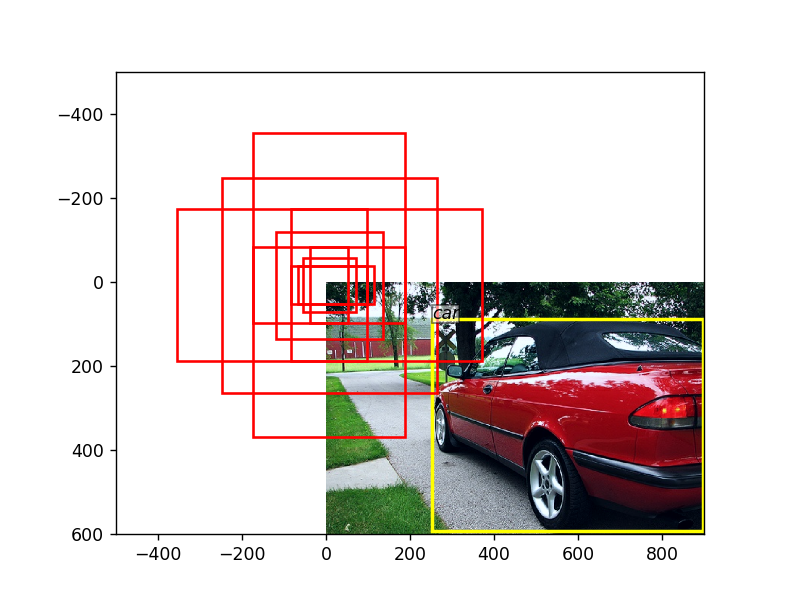

W0708 21:26:12.287340  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)
ax.set_xlim(-500)
ax.set_ylim(600, -500)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

for i in range(0,10):
    y1 = anchor[i][0]
    x1 = anchor[i][1]
    y2 = anchor[i][2]
    x2 = anchor[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [23]:
from utils.anchor import loc2bbox

<IPython.core.display.Javascript object>


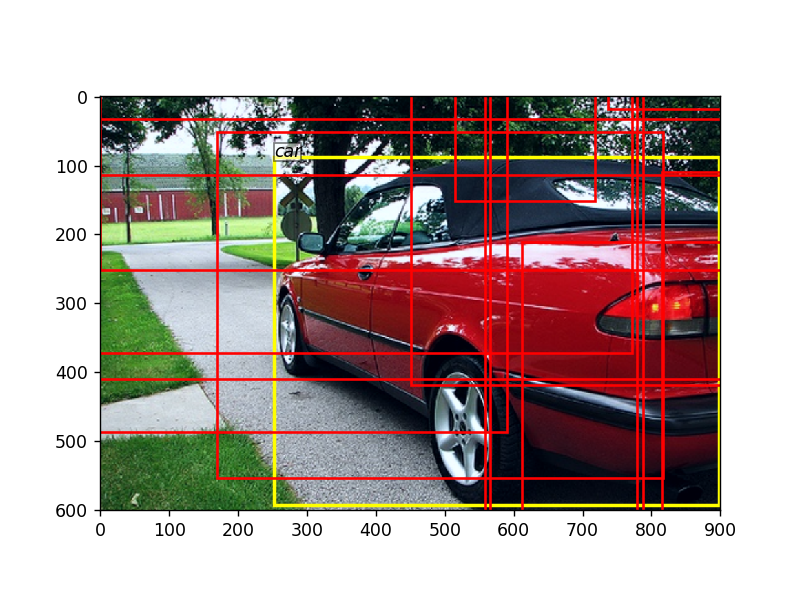

W0708 21:26:15.918420  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

rpn_bbox = loc2bbox(anchor, tf.reshape(rpn_locs, [-1,4]).numpy())
for i in range(1000,10000,500):
    y1 = rpn_bbox[i][0]
    x1 = rpn_bbox[i][1]
    y2 = rpn_bbox[i][2]
    x2 = rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [25]:
gt_rpn_loc, gt_rpn_label = model.anchor_target_creator(bboxes, anchor, img_size)

In [26]:
# 这个对于每一张图是固定的，和训练了多久无关。
for x in (gt_rpn_loc, gt_rpn_label):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (19494, 4) max: 5.735298 min: -2.9267602
shape: (19494,) max: 1 min: -1


In [27]:
x = gt_rpn_loc[gt_rpn_label != -1]
print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (256, 4) max: 5.735298 min: -2.3363197


这是训练一段时间后的

In [29]:
_fast_rcnn_loc_loss(rpn_locs, gt_rpn_loc, gt_rpn_label, 3.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0007704224>

In [30]:
training_index = gt_rpn_label != -1

assert len(gt_rpn_loc[training_index]) == 256

training_anchor = anchor[training_index]
training_rpn_locs = tf.reshape(rpn_locs,[-1, 4])[training_index]
training_rpn_scores = tf.reshape(rpn_scores,[-1, 2])[training_index]

<IPython.core.display.Javascript object>


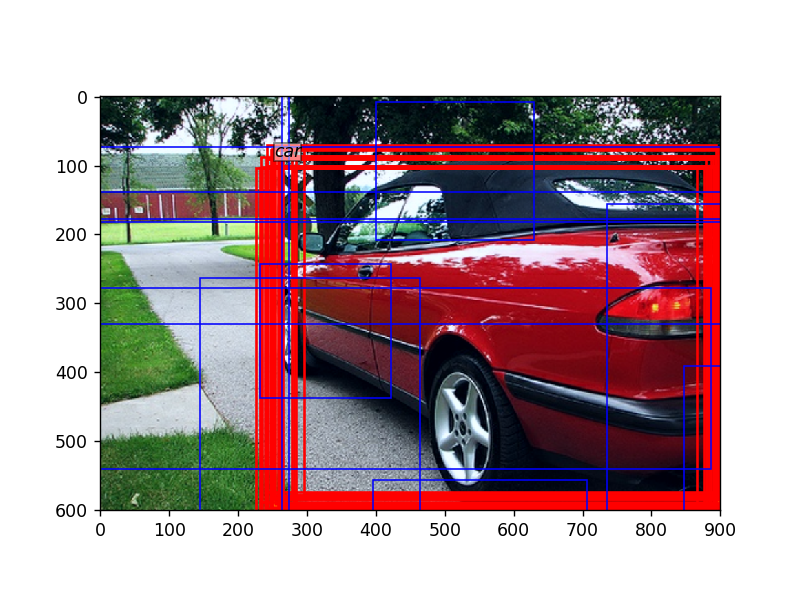

W0708 21:26:35.685488  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [31]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

pos_rpn_bbox = rpn_bbox[gt_rpn_label == 1]
for i in range(len(pos_rpn_bbox)):
    y1 = pos_rpn_bbox[i][0]
    x1 = pos_rpn_bbox[i][1]
    y2 = pos_rpn_bbox[i][2]
    x2 = pos_rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))


neg_rpn_bbox = rpn_bbox[gt_rpn_label == 0]
for i in range(0, len(neg_rpn_bbox), 20):
    y1 = neg_rpn_bbox[i][0]
    x1 = neg_rpn_bbox[i][1]
    y2 = neg_rpn_bbox[i][2]
    x2 = neg_rpn_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='blue', linewidth=0.9))


In [32]:
rpn_target_bbox = loc2bbox(anchor, gt_rpn_loc)

<IPython.core.display.Javascript object>


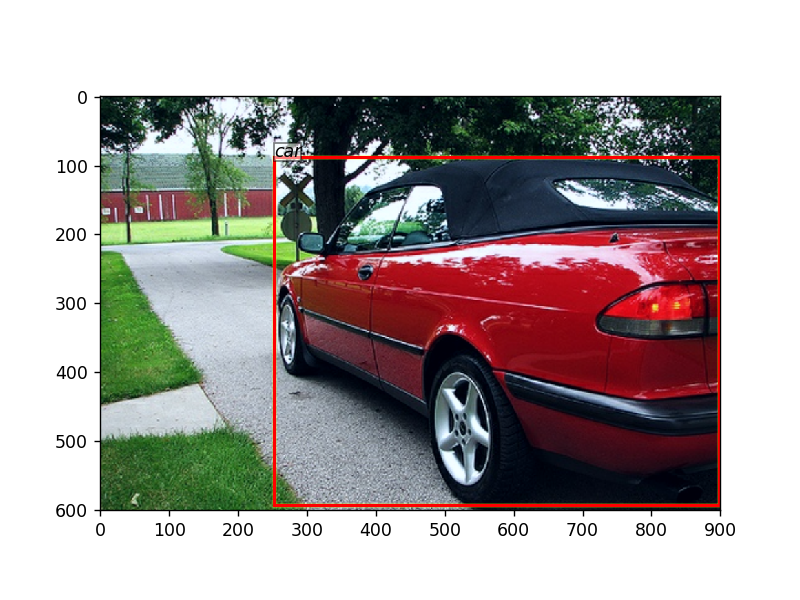

W0708 21:26:51.017385  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [34]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

pos_rpn_target_bbox = rpn_target_bbox[gt_rpn_label == 1]
for i in range(len(pos_rpn_target_bbox)):
    y1 = pos_rpn_target_bbox[i][0]
    x1 = pos_rpn_target_bbox[i][1]
    y2 = pos_rpn_target_bbox[i][2]
    x2 = pos_rpn_target_bbox[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [35]:
tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(gt_rpn_label[training_index], rpn_scores[0][training_index])

<tf.Tensor: shape=(), dtype=float32, numpy=1.1920928e-07>

In [36]:
rois[0]

array([ 40.24063, 550.94305, 557.65234, 900.     ], dtype=float32)

<IPython.core.display.Javascript object>


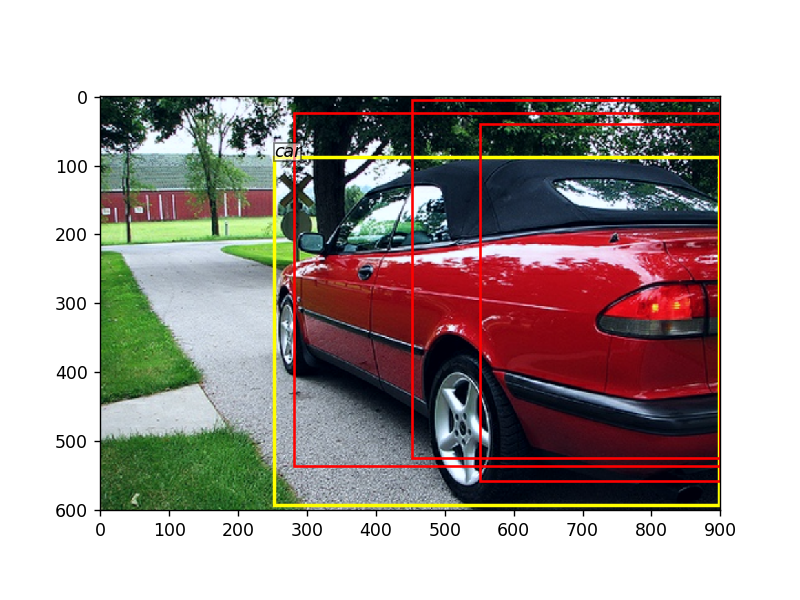

W0708 21:27:10.115751  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [38]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})


for i in range(3):
    y1 = rois[i][0]
    x1 = rois[i][1]
    y2 = rois[i][2]
    x2 = rois[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [39]:
sample_roi, gt_roi_loc, gt_roi_label = model.proposal_target_creator(rois, bboxes, labels)

In [40]:
for x in (sample_roi, gt_roi_loc, gt_roi_label):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (128, 4) max: 900.0 min: 0.0
shape: (128, 4) max: 13.235157 min: -10.720947
shape: (128,) max: 7 min: 0


In [44]:
roi_cls_loc, roi_score = model.faster_rcnn.head(feature_map, sample_roi, img_size)

In [45]:
for x in (roi_cls_loc, roi_score):
    print('shape:', x.shape, 'max:', tf.reduce_max(x).numpy(), 'min:', tf.reduce_min(x).numpy())

shape: (128, 84) max: 5.849859 min: -4.674736
shape: (128, 21) max: 134.48218 min: -20.153297


In [47]:
gt_roi_label

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>


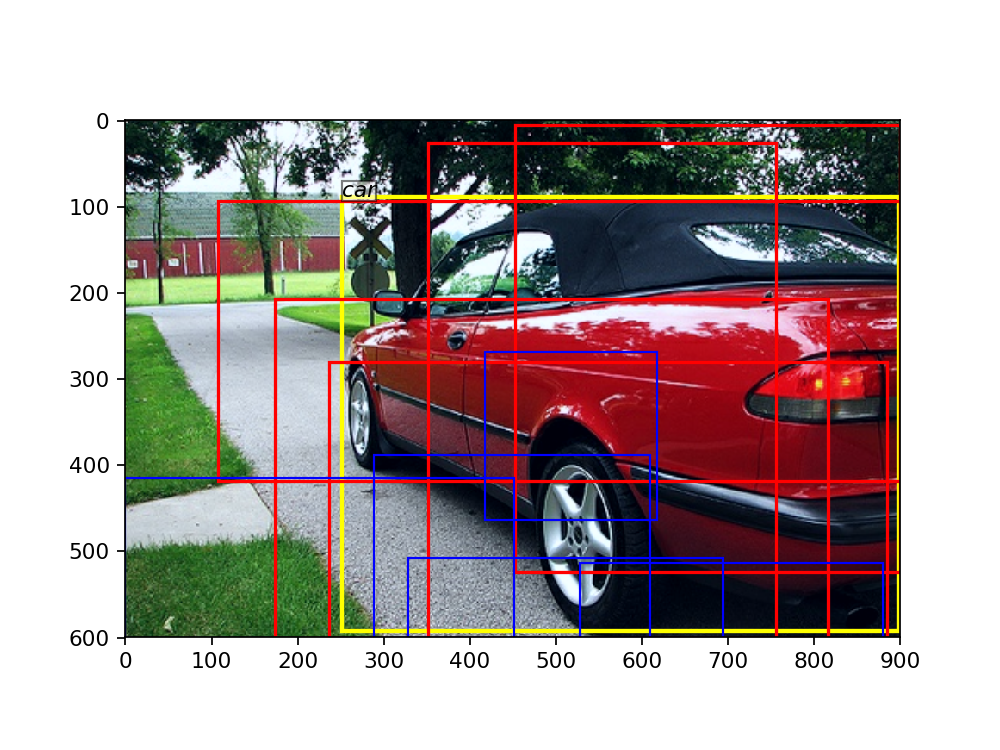

W0708 22:05:22.189180  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [49]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})


for i in range(5):
    y1 = sample_roi[i][0]
    x1 = sample_roi[i][1]
    y2 = sample_roi[i][2]
    x2 = sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

for i in range(100, 105):
    y1 = sample_roi[i][0]
    x1 = sample_roi[i][1]
    y2 = sample_roi[i][2]
    x2 = sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='blue', linewidth=1))

In [51]:
# ROI losses
n_sample = roi_cls_loc.shape[0]
roi_cls_loc = tf.reshape(roi_cls_loc, [n_sample, -1, 4])
idx_ = [[i, j] for i, j in zip(tf.range(n_sample), tf.constant(gt_roi_label))]
roi_loc = tf.gather_nd(roi_cls_loc, idx_)

<IPython.core.display.Javascript object>


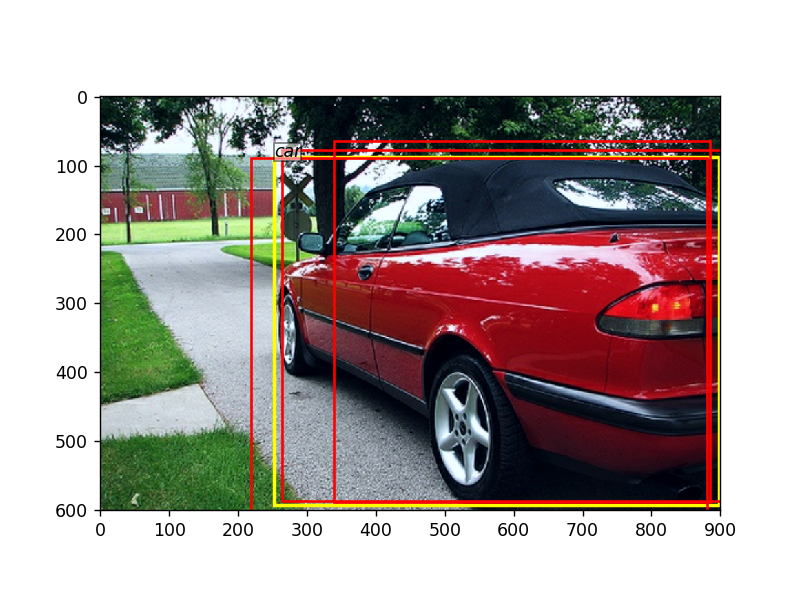

W0708 22:09:19.710295  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [52]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})


modified_sample_roi = loc2bbox(sample_roi, roi_loc.numpy())
for i in range(3):
    y1 = modified_sample_roi[i][0]
    x1 = modified_sample_roi[i][1]
    y2 = modified_sample_roi[i][2]
    x2 = modified_sample_roi[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))

In [53]:
prob = tf.nn.softmax(roi_score, axis=-1)
prob = prob.numpy()
roi_cls_loc = roi_cls_loc.numpy()
roi_cls_loc = roi_cls_loc.reshape(-1, 21, 4)  # 128, 21, 4

In [55]:
modi_roi_bboxes = []
modi_roi_labels = []
modi_roi_scores = []

In [56]:
for label_index in range(1, 21):

    cls_bbox = loc2bbox(sample_roi, roi_cls_loc[:, label_index, :])
    # clip bounding box
    cls_bbox[:, 0::2] = tf.clip_by_value(cls_bbox[:, 0::2], clip_value_min=0, clip_value_max=img_size[0])
    cls_bbox[:, 1::2] = tf.clip_by_value(cls_bbox[:, 1::2], clip_value_min=0, clip_value_max=img_size[1])
    cls_prob = prob[:, label_index]

    mask = cls_prob > 0.05
    cls_bbox = cls_bbox[mask]
    cls_prob = cls_prob[mask]
    keep = tf.image.non_max_suppression(cls_bbox, cls_prob, max_output_size=-1, iou_threshold=0.5)

    if len(keep) > 0:
        modi_roi_bboxes.append(cls_bbox[keep.numpy()])
        # The labels are in [0, self.n_class - 2].
        modi_roi_labels.append((label_index - 1) * np.ones((len(keep),)))
        modi_roi_scores.append(cls_prob[keep.numpy()])
if len(bboxes) > 0:
    modi_roi_bboxes = np.concatenate(modi_roi_bboxes, axis=0).astype(np.float32)
    modi_roi_labels = np.concatenate(modi_roi_labels, axis=0).astype(np.float32)
    modi_roi_scores = np.concatenate(modi_roi_scores, axis=0).astype(np.float32)

In [57]:
modi_roi_labels

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.], dtype=float32)

<IPython.core.display.Javascript object>


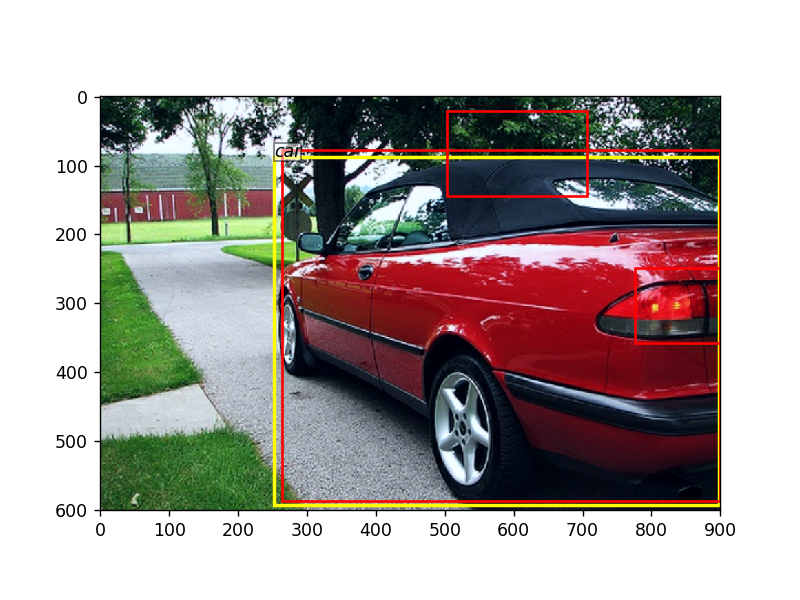

W0708 22:13:40.750300  7584 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [60]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)

for i in range(len(bboxes)):
    y1 = bboxes[i][0]
    x1 = bboxes[i][1]
    y2 = bboxes[i][2]
    x2 = bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='yellow', linewidth=2))
    ax.text(x1,y1,VOC_BBOX_LABEL_NAMES[labels[i]],style='italic',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0})

for i in range(3):
    y1 = modi_roi_bboxes[i][0]
    x1 = modi_roi_bboxes[i][1]
    y2 = modi_roi_bboxes[i][2]
    x2 = modi_roi_bboxes[i][3]
    height = y2 - y1
    width = x2 - x1
    ax.add_patch(plt.Rectangle((x1,y1), width, height, fill=False, edgecolor='red', linewidth=1.5))